# import libraries

In [38]:
import matplotlib; matplotlib.use('agg')
import mvpa2.suite as mv
import numpy as np
import pandas as pd
from scipy import stats
from scipy.io import wavfile
import sys, os, time, csv
from sklearn.linear_model import RidgeCV
from nilearn.plotting import plot_surf
import matplotlib.pyplot as plt
from tikreg import models
from tikreg import utils as tikutils

from tikreg import models, utils as tikutils
from tikreg import spatial_priors, temporal_priors


In [81]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7., 7.]
matplotlib.rcParams['font.size'] = 15


# parameters

In [4]:
participants = ['sub-rid000001']
hemispheres = ['lh']

tr_movie = {1:369, 2:341, 3:372, 4:406}
tr_fmri = {1:374, 2:346, 3:377, 4:412}
tr_length = 2.5
n_samples = 1509
n_vertices = 40962
n_proc = 32     # how many cores do we have?
n_medial = {'lh': 3486, 'rh': 3491}

# mvpa_dir = '/idata/DBIC/cara/life/pymvpa/'
sam_data_dir = '/Users/h/Documents/projects_local/life-encoding-sandbox/data'
# ridge_dir = '/idata/DBIC/cara/life/ridge'
# cara_data_dir = '/idata/DBIC/cara/life/data'
npy_dir = '/Users/h/Documents/projects_local/life-encoding-sandbox/w2v_features'


# functions

In [5]:
def get_visual_stim_for_fold(stimfile, fold_shifted, included):
    cam = np.load(os.path.join(npy_dir, '{0}.npy'.format(stimfile)))
    # motion = np.load('/ihome/cara/global_motion/motion_downsampled_complete.npy')
    #
    # motion_list = []
    # motion_list.append(motion[:369])
    # motion_list.append(motion[369:710])
    # motion_list.append(motion[710:1082])
    # motion_list.append(motion[1082:])

    full_stim = []
    full_stim.append(cam[:369,:])
    full_stim.append(cam[369:710,:])
    full_stim.append(cam[710:1082,:])
    full_stim.append(cam[1082:,:])

    for i in range(len(full_stim)):
        # m = motion_list[i]
    	# m_avg = np.mean(np.vstack((m[3:], m[2:-1], m[1:-2], m[:-3])),axis=0)
    	# m_avg = np.reshape(m_avg,(-1,1))

        this = full_stim[i]
        # full_stim[i] = np.concatenate((m_avg, this[3:,:], this[2:-1,:], this[1:-2,:], this[:-3,:]), axis=1)
        full_stim[i] = np.concatenate((this[3:,:], this[2:-1,:], this[1:-2,:], this[:-3,:]), axis=1)

    train_stim = [full_stim[i] for i in np.subtract(included, 1)]
    test_stim = full_stim[fold_shifted-1]

    return train_stim, test_stim

In [6]:
def get_mel():
    mel_list = [[],[],[],[]]
    directory = os.path.join(cara_data_dir, 'spectral', 'complete')
    for f in os.listdir(directory):
        if 'csv' in f:
            run = int(f[-5])
            s = pd.read_csv(os.path.join(directory, f))
            filter_col = [col for col in s if col.startswith('mel')]
            tr_s = np.array(s[filter_col])
            tr_avg = np.mean(tr_s, axis=1)

            groupby = tr_avg.shape[0] / tr_movie[run]
            remainder = tr_avg.shape[0] % tr_movie[run]
            tr_reshaped = np.reshape(tr_avg[:-remainder], (tr_movie[run], groupby))
            avg = np.mean(tr_reshaped, axis=1)
            mel_list[run-1] = avg
    return mel_list

In [7]:
def get_ws_data(test_p, fold_shifted, included, hemi):
    print('\nLoading fMRI GIFTI data for HA in test subj space and using {0} as test participant...'.format(test_p))
    train_resp = []
    for run in included:
        avg = []
        if run == 4:
            resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[run], run, hemi))).samples[4:-5,:]
        else:
            resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[run], run, hemi))).samples[4:-4,:]

        resp = resp[:,cortical_vertices[hemi] == 1]
        mv.zscore(resp, chunks_attr=None)
        print('train', run, resp.shape)

        train_resp.append(resp)

    if fold_shifted == 4:
        test_resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[fold_shifted], fold_shifted, hemi))).samples[4:-5,:]
    else:
        test_resp = mv.gifti_dataset(os.path.join(sam_data_dir, '{0}_task-life_acq-{1}vol_run-0{2}.{3}.tproject.gii'.format(test_p, tr_fmri[fold_shifted], fold_shifted, hemi))).samples[4:-4,:]

    test_resp = test_resp[:,cortical_vertices[hemi] == 1]
    mv.zscore(test_resp, chunks_attr=None)
    print('test', fold_shifted, test_resp.shape)

    return train_resp, test_resp

# sandbox parameters

In [8]:
model = 'visual'
align = 'ws'
# stimfile = 'all'
fold = 1
fold_shifted = fold+1
hemi = 'lh'
included = [1,2,3,4]
included.remove(fold_shifted)
test_p = 'sub-rid000001'

In [9]:
cortical_vertices = {}
for half in ['lh', 'rh']:
    test_ds = mv.niml.read('/Users/h/Documents/projects_local/life-encoding-sandbox/niml/ws.lh.niml.dset'.format(half))
    cortical_vertices[half] = np.ones((n_vertices))
    cortical_vertices[half][np.sum(test_ds.samples[1:, :] != 0, axis=0) == 0] = 0

/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/support/nibabel/afni_niml.py:182: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data_1d = np.fromstring(s, dtype=tp)


## features bg & action

In [10]:
stimfile = 'bg'
X1train_stim, X1test_stim = get_visual_stim_for_fold('{0}_{1}'.format(model, stimfile), fold_shifted, included)

stimfile = 'actions'
X2train_stim, X2test_stim = get_visual_stim_for_fold('{0}_{1}'.format(model, stimfile), fold_shifted, included)

Ytrain_uncon, Ytest = get_ws_data(test_p, fold_shifted, included, hemi)



Loading fMRI GIFTI data for HA in test subj space and using sub-rid000001 as test participant...


/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/datasets/gifti.py:77: DeprecationWarning: giftiio.read function deprecated. Use nibabel.load() instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  samples = giftiio.read(samples)


('train', 1, (366, 37476))
('train', 3, (369, 37476))
('train', 4, (403, 37476))
('test', 2, (338, 37476))


In [31]:
# concatenate 3 runs
X1train = np.concatenate(X1train_stim)
X2train = np.concatenate(X2train_stim)

Ytrain = np.concatenate(Ytrain_uncon)

print(X1train.shape, "X1train" )
print(X2train.shape, "X2train")
print(X1test_stim.shape, "X1test_stim")
print(X2test_stim.shape, "X2test_stim")
print(Ytest.shape, "Ytest")
print(Ytrain.shape, "Ytrain")

((1138, 1200), 'X1train')
((1138, 1200), 'X2train')
((338, 1200), 'X1test_stim')
((338, 1200), 'X2test_stim')
((338, 37476), 'Ytest')
((1138, 37476), 'Ytrain')


# tikreg - one example

In [12]:

# Sampling in terms of ratios and scalings
alphas = np.logspace(0,4,11)
ratios = np.logspace(-2,2,25)

# Solve for one hyperparameter set only
# We will use this solution to test the tikreg implementation
ratio = ratios[16]
alpha = alphas[1]

angle = np.arctan(ratio)
lambda_one = np.cos(angle)*alpha
lambda_two = np.sin(angle)*alpha


bands = np.asarray([lambda_one]*X1train.shape[1] + [lambda_two]*X2train.shape[1])
Cinv = np.diag(bands**-1)

A = np.hstack([X1train/lambda_one, X2train/lambda_two])
U, S, VT = np.linalg.svd(A, full_matrices=False)
V = VT.T
UTY = np.dot(U.T, Ytrain)
D = np.diag(S / (S**2 + alpha**2))

solution_svd_standard = np.linalg.multi_dot([V, D, UTY])*alpha
solution_svd_bandstd2tik = np.dot(Cinv, solution_svd_standard)

print(np.rad2deg(angle), ratio, alpha, lambda_one, lambda_two)


(77.84183577448114, 4.6415888336127775, 2.51188643150958, 0.5290310600635536, 2.455544661025322)


In [16]:
# Use tikreg to find the solution
X1_prior = spatial_priors.SphericalPrior(X1train, hyparams=[lambda_one])
X2_prior = spatial_priors.SphericalPrior(X2train, hyparams=[lambda_two])
# A temporal prior is unnecessary, so we specify no delays
temporal_prior = temporal_priors.SphericalPrior(delays=[0]) # no delays

fit_banded_polar = models.estimate_stem_wmvnp([X1train, X2train], Ytrain,
                                              [X1test_stim, X2test_stim],Ytest,
                                              feature_priors=[X1_prior, X2_prior],
                                              temporal_prior=temporal_prior,
                                              ridges=[alpha],
                                              folds=(1,5), # 1x 5-fold cross-validation
                                              performance=True,
                                              weights=True,
                                              verbosity=False)

In [18]:
voxelwise_optimal_hyperparameters = fit_banded_polar['optima']
print(voxelwise_optimal_hyperparameters.shape)

(37476, 4)


# voxelwise

In [33]:
# voxelwise
alphas = voxelwise_optimal_hyperparameters[:,-1]
lambda_ones = voxelwise_optimal_hyperparameters[:,1]
lambda_twos = voxelwise_optimal_hyperparameters[:,2]
kernel_weights = fit_banded_polar['weights']
weights_x1 = np.linalg.multi_dot([X1train.T, kernel_weights, np.diag(alphas), np.diag(lambda_ones**-2)])
weights_x2 = np.linalg.multi_dot([X2train.T, kernel_weights, np.diag(alphas), np.diag(lambda_twos**-2)])


# correlation coefficient

In [34]:
actual_df = pd.DataFrame(data = Ytest)
estimated_x1 = pd.DataFrame(data = weights_x1)
estimated_x2 = pd.DataFrame(data = weights_x2)
corr_x1 = pd.DataFrame.corrwith(estimated_x1, actual_df, axis = 0, method = 'pearson')
corr_x2 = pd.DataFrame.corrwith(estimated_x2, actual_df, axis = 0, method = 'pearson')

# save niml

In [36]:
med_wall_ind = np.where(cortical_vertices[hemi] == 0)[0]
out = np.zeros((corr_x1.shape[0]+med_wall_ind.shape[0]),dtype=np.dtype(corr_x1).type)
out[cortical_vertices[hemi] == 1] =corr_x1
mv.niml.write('/Users/h/Documents/projects_local/life-encoding-sandbox/X1_bg.niml.dset', out[None,:])

out = np.zeros((corr_x2.shape[0]+med_wall_ind.shape[0]),dtype=np.dtype(corr_x2).type)
out[cortical_vertices[hemi] == 1] =corr_x2
mv.niml.write('/Users/h/Documents/projects_local/life-encoding-sandbox/X2_actions.niml.dset', out[None,:])

/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/support/nibabel/afni_niml_types.py:78: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.string_ == np.dtype(str).type`.
  (np.issubdtype(data.dtype, np.str) or data.dtype.kind in 'US')
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/support/nibabel/afni_niml_types.py:69: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return type(data) is np.ndarray and np.issubdtype(data.dtype, float)
/Users/h/anaconda3/envs/pymvpa_env/lib/python2.7/site-packages/mvpa2/support/nibabel/afni_niml_types.py:65: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  return type(da

# plot


In [90]:

surface_dir = '/Users/h/suma-fsaverage6'
sandbox_dir = '/Users/h/Documents/projects_local/life-encoding-sandbox'
fsaverage_gii_L = os.path.join(surface_dir ,  'lh.pial.gii')
fsaverage_gii_R = os.path.join(surface_dir , 'rh.pial.gii')
fsaverage_inflated_L = os.path.join(surface_dir , 'lh.inf_50.gii')
fsaverage_inflated_R = os.path.join(surface_dir , 'rh.inf_50.gii')

sub_file_name = os.path.join(sandbox_dir, 'X1_bg.niml.dset')
X1 = mv.niml.read(sub_file_name)

X2_file_name = os.path.join(sandbox_dir, 'X2_actions.niml.dset')
X2 = mv.niml.read(sub_file_name)

In [97]:
np.asarray(ds.samples[0])



array([-0.02680659, -0.07120993, -0.03554899, ...,  0.01377774,
       -0.02796944, -0.03744206], dtype=float32)

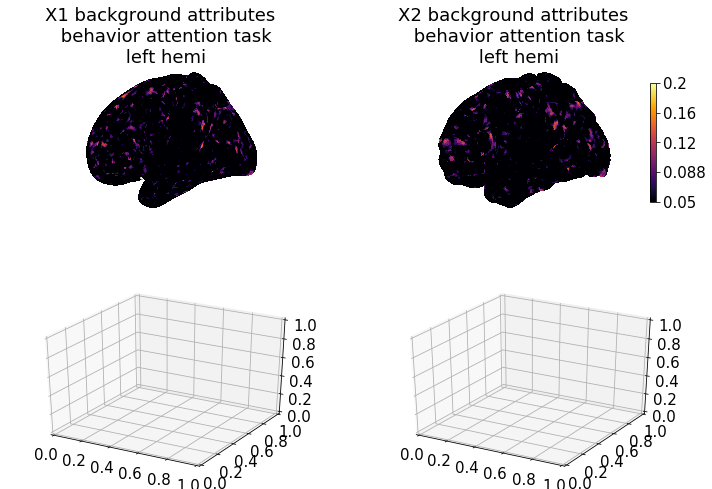

In [98]:
# f, axs = plt.subplots(2, 2)
figure, axes = plt.subplots(1,2,subplot_kw={'projection': '3d'},figsize = (12,8))
plot_surf(fsaverage_inflated_L,np.asarray(X1.samples[0]), 
          title='X1 background attributes \n behavior attention task\n left hemi', 
          hemi='left', view = 'lateral', vmin=.05, vmax=.20, cmap = 'plasma',axes=axes[0][0])
plot_surf(fsaverage_gii_L,np.asarray(X2.samples[0]), colorbar = True,
          title='X2 background attributes \n behavior attention task\n left hemi', 
          hemi='left', view = 'lateral', vmin=.05, vmax=.20, cmap = 'plasma',axes=axes[0][1])
# plot_surf(fsaverage_inflated_L,mean_cl20_taxtask_L, 
#           title='1-out-of-20 classification \n taxonomy attention task\n left hemi', 
#           hemi='left', view = 'lateral', vmin=.05, vmax=.20, cmap = 'inferno',axes=axes[1][0])
# plot_surf(fsaverage_inflated_R,mean_cl20_taxtask_R, colorbar = True,
#           title='1-out-of-20 classification \n taxonomy attention task\n right hemi', 
#           hemi='right', view = 'lateral', vmin=.05, vmax=.20, cmap = 'inferno',axes=axes[1][1])
plt.show()

# verification - flag

In [17]:
lambda_one_scaled, lambda_two_scaled = fit_banded_polar['spatial'].squeeze()
ridge_scaled = fit_banded_polar['ridges'].squeeze()
print(lambda_one_scaled, lambda_two_scaled, ridge_scaled)
kernel_weights = fit_banded_polar['weights']

Xtmp = np.c_[X1train/lambda_one_scaled, X2train/lambda_two_scaled]
weights_standard = np.dot(Xtmp.T, kernel_weights*alpha)

# Standard form solutions
weights_x1 = weights_standard[:X1train.shape[1],:]
weights_x2 = weights_standard[X1train.shape[1]:,:]

sweights_x1 = solution_svd_standard[:X1train.shape[1],:]
sweights_x2 = solution_svd_standard[X1train.shape[1]:,:]

print('Standard transform weights for X1:')
print(weights_x1[:1,:5])
print(sweights_x1[:1,:5])
print(np.corrcoef(weights_x1.ravel(), sweights_x1.ravel())[0,1])
print(np.allclose(weights_x1, sweights_x1))

print('Standard transform weights for X2:')
print(weights_x2[:1,:5])
print(sweights_x2[:1,:5])
print(np.corrcoef(weights_x2.ravel(), sweights_x2.ravel())[0,1])
print(np.allclose(weights_x2, sweights_x2))

assert np.allclose(weights_standard, solution_svd_standard)


# TIkhonov solutions
bands = np.asarray([lambda_one_scaled]*X1train.shape[1] + [lambda_two_scaled]*X1train.shape[1])
Cinv = np.diag(bands**-1.0)
weights = np.dot(Cinv, weights_standard)

# full eq: np.dot(np.hstack([X1/(lambda_one_scaled**2.), X2/(lambda_two_scaled**2.)]).T, kernel_weights*alpha)
weights_x1t = weights[:X1train.shape[1],:]
weights_x2t = weights[X1train.shape[1]:,:]

tweights_x1 = solution_svd_bandstd2tik[:X1train.shape[1],:]
tweights_x2 = solution_svd_bandstd2tik[X1train.shape[1]:,:]

print('Tikhonov weights for joint model')
print(weights_x1t[:1,:5])
print(tweights_x1[:1,:5])
print(np.corrcoef(weights_x1t.ravel(), tweights_x1.ravel())[0,1])
print(weights_x2t[:1,:5])
print(tweights_x2[:1,:5])
print(np.corrcoef(weights_x2t.ravel(), tweights_x2.ravel())[0,1])

print('Full model weights')
print(np.corrcoef(weights.ravel(),  solution_svd_bandstd2tik.ravel())[0,1])
assert np.allclose(weights,  solution_svd_bandstd2tik)
print(weights.shape)

(0.5290310600635536, 2.455544661025322, array(2.51188643))
Standard transform weights for X1:
[[0.31271817 0.085928   0.04817397 0.44378632 0.05551227]]
[[0.3127062  0.08593173 0.0481875  0.44379273 0.05549034]]
0.9999999977802349
False
Standard transform weights for X2:
[[ 0.12628397 -0.07531208  0.19133092 -0.34598482 -0.15550639]]
[[ 0.12626712 -0.07530233  0.19131272 -0.34596205 -0.15547659]]
0.999999992806901
False


AssertionError: 